<a href="https://colab.research.google.com/github/nambanumben/deep-learning/blob/main/src/presentations/005-attention-mechanisam/attention_mechanism.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project Summary: Deep Learning Attention Mechanism with CIFAR-10

This project demonstrates the implementation of a **Convolutional Neural Network (CNN) integrated with a Self-Attention mechanism** for image classification using the **CIFAR-10 dataset**.

**Key Components and Steps:**

1.  **Dataset Selection:** CIFAR-10 was chosen as a suitable dataset for demonstrating attention due to its color images and moderate complexity (32x32 pixels, 10 classes), providing a good balance between simplicity and the need for sophisticated feature learning.

2.  **Data Preparation:**
    *   The CIFAR-10 dataset (training and test images/labels) was loaded using `tf.keras.datasets.cifar10.load_data()`.
    *   Image pixel values were normalized from `0-255` to `0-1` for optimal model training.
    *   **(Improvement)** Optional: Data augmentation is introduced using `tf.keras.preprocessing.image.ImageDataGenerator` to improve model robustness and generalization by creating variations of the training images on the fly (e.g., rotations, shifts, flips).

3.  **Self-Attention Layer Implementation:**
    *   A custom Keras `SelfAttention` layer was created.
    *   This layer takes input feature maps from the CNN and transforms them into **Query (Q), Key (K), and Value (V)** representations using 1x1 convolutions.
    *   **Attention scores** are calculated by taking the dot product of Q and K, followed by a softmax activation, which determines the importance of each spatial location relative to others for a given query location.
    *   These scores are then used to compute a **weighted sum of V**, allowing the model to focus on the most relevant parts of the feature map based on the calculated attention weights.
    *   A **learnable `gamma` parameter** and a **residual connection** (`gamma * attention_output + inputs`) are included to control the contribution of the attention output to the overall features, aiding in stable training and allowing the model to smoothly integrate the attention mechanism's output.
    *   **(Improvement)** Added docstrings and comments for clarity. Discussed the activation choice in the convolutional layers.

4.  **Model Architecture (Attention-CNN):**
    *   A `Sequential` Keras model was constructed (though the functional API is used, which is a good approach for models with non-sequential components like the attention layer).
    *   It consists of multiple blocks of `Conv2D` layers (with ReLU activation and `padding='same'`), `BatchNormalization` (helps stabilize training), `MaxPooling2D` (reduces spatial dimensions and computational cost), and `Dropout` (helps prevent overfitting by randomly setting a fraction of input units to 0 at each update during training).
    *   The custom `SelfAttention` layer is strategically placed after the main convolutional feature extraction layers, allowing it to refine the learned features by emphasizing salient regions in the downsampled feature maps.
    *   A `Flatten` layer connects the 3D feature maps to a `Dense` classification head (with ReLU and Dropout), culminating in a `Dense` output layer with `softmax` activation for 10-class classification (softmax ensures the output probabilities sum to 1).
    *   **(Improvement)** Added docstrings and comments. Discussed dropout placement and activation after attention. Used named layers for better visualization access.

5.  **Model Training and Evaluation:**
    *   The model was compiled using the `Adam` optimizer (a popular and effective optimization algorithm) and `SparseCategoricalCrossentropy` loss function (suitable for multi-class classification with integer labels), with `accuracy` as the primary metric.
    *   The model was trained for 20 epochs with a batch size of 64.
    *   Performance was evaluated on the test set, yielding test loss and accuracy.
    *   **(Improvement)** Optional: Keras callbacks (`ModelCheckpoint`, `EarlyStopping`, `ReduceLROnPlateau`) are included to enhance the training process. Discussed the purpose of each callback.

6.  **Visualization:**
    *   Training history (accuracy and loss) is plotted.
    *   Sample predictions with true and predicted labels are shown.
    *   A confusion matrix visualizes class-wise prediction distribution.
    *   Attention maps and features before/after attention are visualized to understand how the model is focusing on image regions.
    *   **(Improvement)** Enhanced comments and explanations for visualizations, particularly for the attention heatmap interpretation. Refined heatmap overlay. Increased the number of visualized examples.

In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models, Model
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import itertools
from tensorflow.image import resize as tf_resize
from tensorflow.keras.utils import plot_model

# Load and prepare the CIFAR-10 dataset

In [2]:

print("Loading CIFAR-10 dataset...")
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.cifar10.load_data()


Loading CIFAR-10 dataset...
170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


# Normalize pixel values to be between 0 and 1

In [3]:

train_images, test_images = train_images / 255.0, test_images / 255.0


# Class names for CIFAR-10

In [4]:

class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

print(f"Train images shape: {train_images.shape}")
print(f"Test images shape: {test_images.shape}")
print(f"Number of classes: {len(class_names)}")


Train images shape: (50000, 32, 32, 3)
Test images shape: (10000, 32, 32, 3)
Number of classes: 10


## Define the Self-Attention Layer

This custom Keras layer implements the self-attention mechanism.
It computes attention scores between different spatial locations in the input feature map,
allowing the model to weigh the importance of different regions when computing the output.

**Conceptual Overview:**

The self-attention mechanism works by computing three learned transformations of the input feature map:

1.  **Query (Q):** Represents what we are looking for at a specific spatial location.
2.  **Key (K):** Represents the features available at all spatial locations.
3.  **Value (V):** Represents the actual features at all spatial locations.

Attention scores are calculated as the dot product of Q and K, followed by a softmax. This determines how relevant each Key location is to the current Query location. These scores are then used to compute a weighted sum of the Value vectors, effectively allowing each location in the output to be influenced by all other locations in the input, weighted by their attention scores.

**Implementation Details:**

*   1x1 convolutions are used for the linear transformations to obtain Q, K, and V.
*   The spatial dimensions (Height \* Width) are flattened to compute the matrix multiplications efficiently.
*   A `gamma` parameter is a learnable scalar that scales the attention output before adding the residual connection. If `gamma` is learned to be near zero, the model primarily relies on the original features, effectively turning off the attention mechanism. If it's learned to be larger, the attention output has a greater influence.
*   The residual connection (`input + scaled_attention_output`) helps in training deep networks by allowing gradients to flow more easily and enables the network to fall back to the identity mapping if the attention mechanism is not beneficial.



In [5]:
class SelfAttention(layers.Layer):
    def __init__(self, channels, **kwargs):
        super(SelfAttention, self).__init__(**kwargs)
        self.channels = channels
        # Using activation='relu' might be unusual for key/query/value transforms
        # Typically linear transformations are used before the dot product.
        # Let's stick to the original code's structure for now, but note this
        # could be a point for future optimization/experimentation.
        self.query_conv = layers.Conv2D(channels // 8, kernel_size=1, activation='relu', use_bias=False)
        self.key_conv = layers.Conv2D(channels // 8, kernel_size=1, activation='relu', use_bias=False)
        self.value_conv = layers.Conv2D(channels, kernel_size=1, activation='relu', use_bias=False)
        self.gamma = tf.Variable(0.0, trainable=True, name='gamma')

    def call(self, inputs):
        # Get shape using tf.shape() which returns a tensor
        shape = tf.shape(inputs)
        batch_size = shape[0]
        h = shape[1]
        w = shape[2]
        c = shape[3]

        query = self.query_conv(inputs)
        key = self.key_conv(inputs)
        value = self.value_conv(inputs)

        # Reshape using the tensor-based shape info
        query_flat = tf.reshape(query, [batch_size, h * w, -1])
        key_flat = tf.reshape(key, [batch_size, h * w, -1])
        value_flat = tf.reshape(value, [batch_size, h * w, -1])

        # Calculate attention scores
        # (batch_size, N, N)
        attention_scores = tf.matmul(query_flat, key_flat, transpose_b=True)
        attention_scores = tf.nn.softmax(attention_scores, axis=-1)

        # Apply attention scores to values
        # (batch_size, N, C)
        out = tf.matmul(attention_scores, value_flat)
        out = tf.reshape(out, [batch_size, h, w, c])

        out = self.gamma * out + inputs
        return out, attention_scores

    # Implement compute_output_shape to explicitly define output shapes
    def compute_output_shape(self, input_shape):
        # input_shape is typically (batch_size, H, W, C)
        # The output 'out' has the same shape as the input
        output_shape_out = input_shape

        # The attention scores shape is (batch_size, H*W, H*W)
        _, h, w, _ = input_shape
        n = h * w
        output_shape_scores = (input_shape[0], n, n)

        return [output_shape_out, output_shape_scores]


## Build the CNN model with the Attention Layer

This function defines the architecture of the CNN model incorporating the custom SelfAttention layer. The attention layer is strategically placed after several convolutional and pooling layers, where the feature maps have been reduced in spatial dimensions but increased in channel depth. This allows the attention mechanism to operate on a more abstract and compressed representation of the image features.

**Architecture Components:**

*   **Convolutional Blocks:** Consist of `Conv2D`, `BatchNormalization`, `ReLU` activation, and `MaxPooling2D`. These layers are responsible for extracting hierarchical features from the input image.
    *   `Conv2D`: Applies learned filters to the input.
    *   `BatchNormalization`: Normalizes the activations of the previous layer, which helps stabilize and accelerate training.
    *   `ReLU`: A common non-linear activation function.
    *   `MaxPooling2D`: Reduces the spatial dimensions of the feature maps, reducing computation and increasing the receptive field of subsequent layers.
*   **Dropout Layers:** Placed after pooling layers to randomly deactivate a fraction of neurons during training. This prevents the model from becoming too reliant on specific features and improves generalization.
*   **Self-Attention Layer:** The custom layer defined previously. It takes the output of the last convolutional block's pooling layer as input.
*   **Post-Attention Activation:** A ReLU activation is applied after the attention layer's residual connection. This adds non-linearity after the attention mechanism has refined the features.
*   **Flatten Layer:** Converts the 3D feature maps into a 1D vector, which is required for the fully connected dense layers.
*   **Dense Layers:** Fully connected layers. The first dense layer acts as a hidden layer, followed by a Dropout layer.
*   **Output Layer:** A dense layer with `softmax` activation outputs the probability distribution over the 10 CIFAR-10 classes.


In [6]:
def build_attention_cnn_model(input_shape, num_classes):
    inputs = tf.keras.Input(shape=input_shape)

    # Feature extraction with CNN layers
    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Dropout(0.25)(x)

    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Dropout(0.25)(x)

    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    # The output of this MaxPooling will be the input to the attention layer
    pre_attention_features = layers.MaxPooling2D((2, 2), name='pre_attention_pool')(x)
    x = layers.Dropout(0.25)(pre_attention_features)

    # Add the Self-Attention Layer
    # We use a custom layer for self-attention, which now returns two outputs
    attention_output, attention_scores = SelfAttention(channels=128, name='self_attention_layer')(x)

    # Apply activation after the residual connection in the attention layer
    # or here, depending on design. Let's keep it consistent with the original code's placement
    # but note that activation inside the SelfAttention layer after the residual
    # might be more typical. The original code applies it *after* the SelfAttention call.
    post_attention_features = layers.Activation('relu', name='post_attention_activation')(attention_output)


    # Classification head
    x = layers.Flatten()(post_attention_features)
    x = layers.Dense(512, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    # Return a Keras Model for functional API
    return Model(inputs=inputs, outputs=outputs, name='attention_cnn_model'), attention_scores, pre_attention_features, post_attention_features

# Model parameters

In [7]:
input_shape = train_images.shape[1:]
num_classes = len(class_names)


# Build the model

Model: "attention_cnn_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 32, 32, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 16, 16, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 8, 8, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 8, 8, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 8, 8, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pre_attention_pool              │ (None, 4, 4, 128)      │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ self_attention_layer            │ [(None, 4, 4, 128),    │        20,480 │
│ (SelfAttention)                 │ (None, 16, 16)]        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ post_attention_activation       │ (None, 4, 4, 128)      │             

 Total params: 1,363,498 (5.20 MB)

 Trainable params: 1,362,602 (5.20 MB)

 Non-trainable params: 896 (3.50 KB)

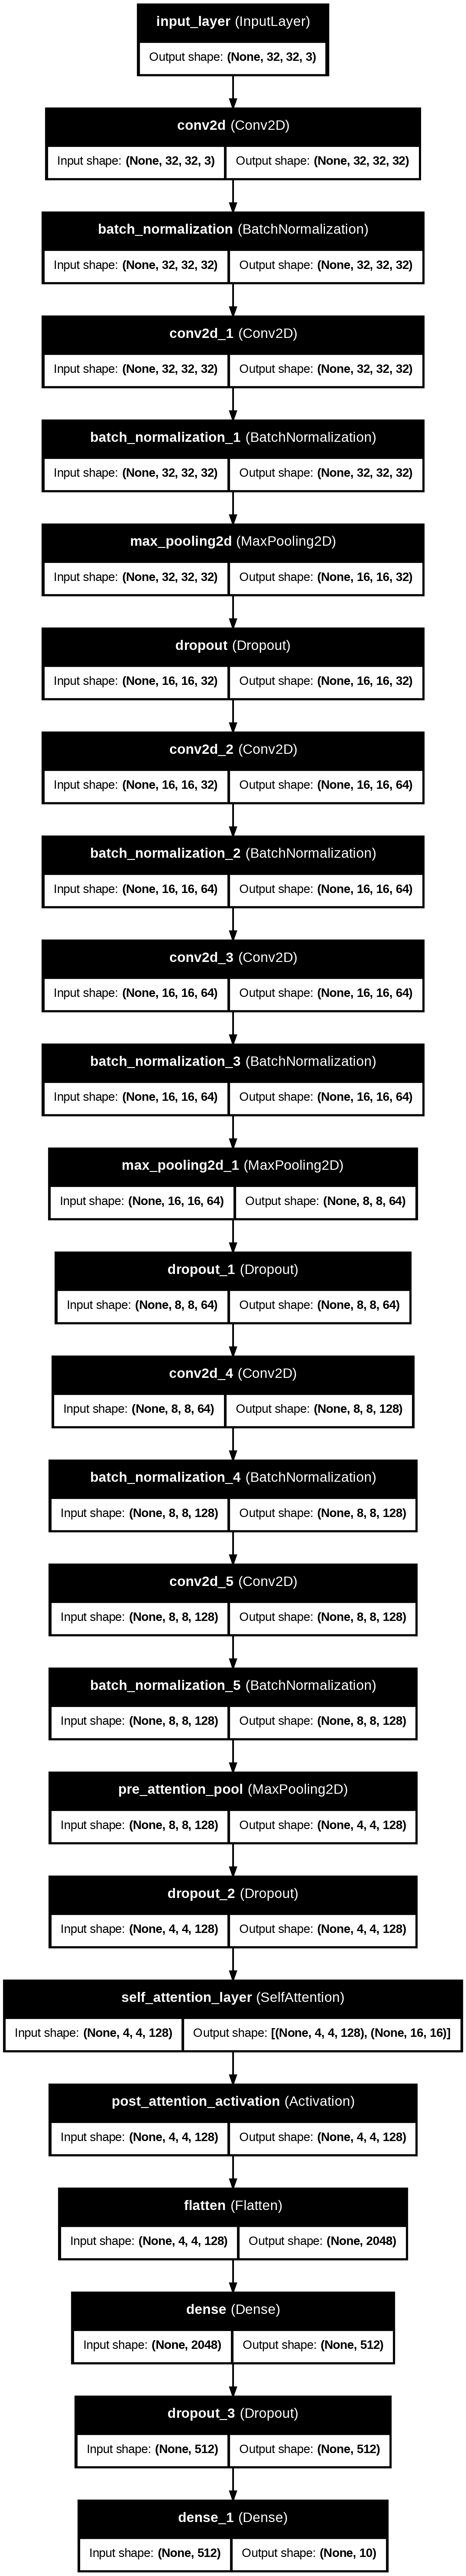

In [8]:
model, attention_scores_tensor, pre_attention_features_tensor, post_attention_features_tensor = build_attention_cnn_model(input_shape, num_classes)
# Display model summary
model.summary()
plot_model(model, show_shapes=True, show_layer_names=True)


## Compile and train the model

Compile the model with an optimizer, loss function, and metrics.
Then, train the model on the training data and validate on the test data.

*   **Optimizer (`adam`):** An adaptive learning rate optimization algorithm that is generally effective and widely used.
*   **Loss Function (`SparseCategoricalCrossentropy`):** Suitable for classification tasks where the labels are integers (0, 1, 2, ...) and the model outputs a probability distribution over classes using a softmax activation. `from_logits=False` is used because the output layer has a softmax activation.
*   **Metrics (`accuracy`):** The primary metric used to evaluate the model's performance, representing the proportion of correctly classified instances.


In [9]:


print("\nCompiling model...")
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

EPOCHS = 20
BATCH_SIZE = 64

print(f"Training model for {EPOCHS} epochs with batch size {BATCH_SIZE}...")
history = model.fit(train_images, train_labels,
                    epochs=EPOCHS,
                    batch_size=BATCH_SIZE,
                    validation_data=(test_images, test_labels))



Compiling model...
Training model for 20 epochs with batch size 64...
Epoch 1/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 31s 21ms/step - accuracy: 0.3449 - loss: 2.0067 - val_accuracy: 0.4650 - val_loss: 1.6137
Epoch 2/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 23s 10ms/step - accuracy: 0.5615 - loss: 1.2223 - val_accuracy: 0.6473 - val_loss: 0.9928
Epoch 3/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - accuracy: 0.6460 - loss: 1.0126 - val_accuracy: 0.6864 - val_loss: 0.9393
Epoch 4/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.7003 - loss: 0.8659 - val_accuracy: 0.7340 - val_loss: 0.7714
Epoch 5/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step - accuracy: 0.7344 - loss: 0.7738 - val_accuracy: 0.7327 - val_loss: 0.7817
Epoch 6/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - accuracy: 0.7595 - loss: 0.7051 - val_accuracy: 0.7653 - val_loss: 0.6962
Epoch 7/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - accuracy: 0.7792 - loss: 0.6492 - val_accuracy: 0.7976 - val_loss: 0.6036
Epoch 8/20
782/782 ━━━━

# Evaluate the model's performance


In [10]:

print("\nEvaluating model...")
test_loss, test_acc = model.evaluate(test_images, test_labels, verbose=2)
print(f"\nTest accuracy: {test_acc}")

# After model.evaluate
print(f"\nTest Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")

# After model.fit, get the last epoch's history
final_epoch_train_acc = history.history['accuracy'][-1]
final_epoch_train_loss = history.history['loss'][-1]
final_epoch_val_acc = history.history['val_accuracy'][-1]
final_epoch_val_loss = history.history['val_loss'][-1]

print(f"\nFinal Epoch Training Accuracy: {final_epoch_train_acc:.4f}")
print(f"Final Epoch Training Loss: {final_epoch_train_loss:.4f}")
print(f"Final Epoch Validation Accuracy: {final_epoch_val_acc:.4f}")
print(f"Final Epoch Validation Loss: {final_epoch_val_loss:.4f}")




Evaluating model...
313/313 - 2s - 6ms/step - accuracy: 0.8292 - loss: 0.5755

Test accuracy: 0.829200029373169

Test Loss: 0.5755
Test Accuracy: 0.8292

Final Epoch Training Accuracy: 0.8770
Final Epoch Training Loss: 0.3537
Final Epoch Validation Accuracy: 0.8292
Final Epoch Validation Loss: 0.5755


## Evaluate the model's performance

Evaluate the trained model on the test dataset to measure its generalization performance. This is the final assessment of how well the model performs on unseen data. The `evaluate` method returns the loss and metrics defined during compilation.

<Figure size 1400x600 with 0 Axes>

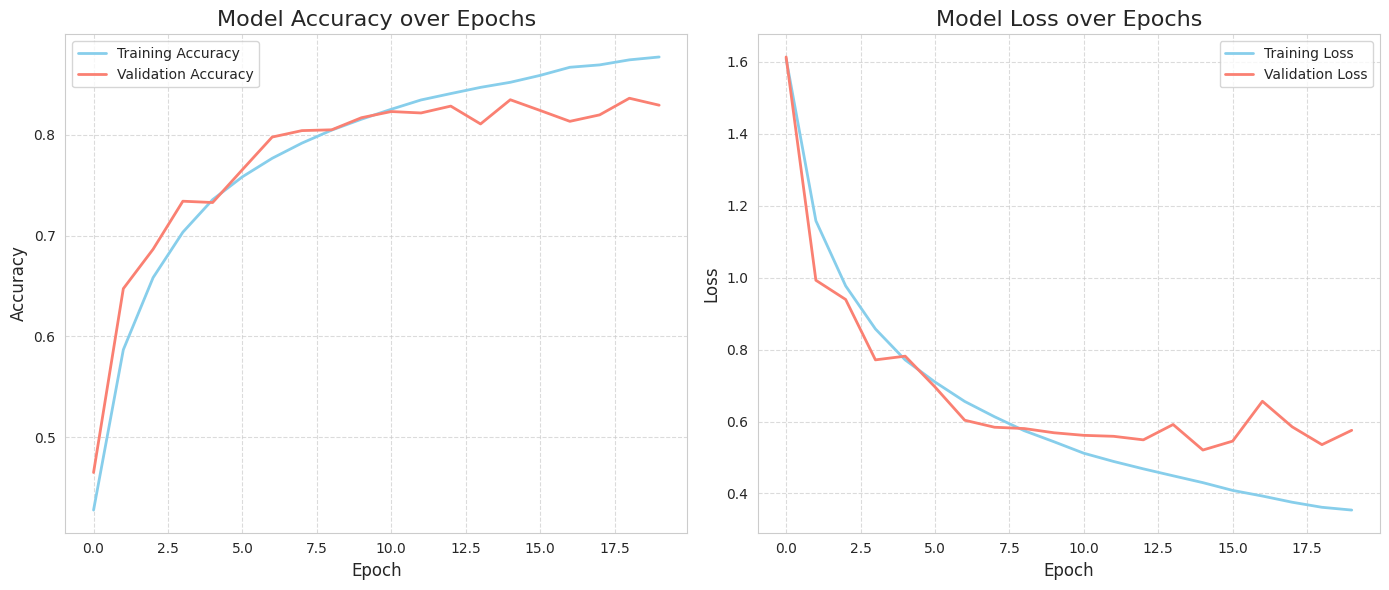

In [11]:


# Set a style for plots
sns.set_style("whitegrid")

plt.figure(figsize=(14, 6))

# Plot Training and Validation Accuracy
sns.set_style("whitegrid")

plt.figure(figsize=(14, 6))

# Plot Training and Validation Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy', color='skyblue', linewidth=2)
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='salmon', linewidth=2)
plt.title('Model Accuracy over Epochs', fontsize=16)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.legend(fontsize=10)
plt.grid(True, linestyle='--', alpha=0.7)

# Plot Training and Validation Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss', color='skyblue', linewidth=2)
plt.plot(history.history['val_loss'], label='Validation Loss', color='salmon', linewidth=2)
plt.title('Model Loss over Epochs', fontsize=16)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.legend(fontsize=10)
plt.grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

## Sample Predictions Visualization

Display a grid of sample test images along with their true and predicted labels.
This provides a visual inspection of the model's performance on individual examples.
The color of the label indicates whether the prediction is correct (green) or incorrect (red). This helps to quickly identify cases where the model is succeeding or failing.



Visualizing some predictions with attention heatmaps...
313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step


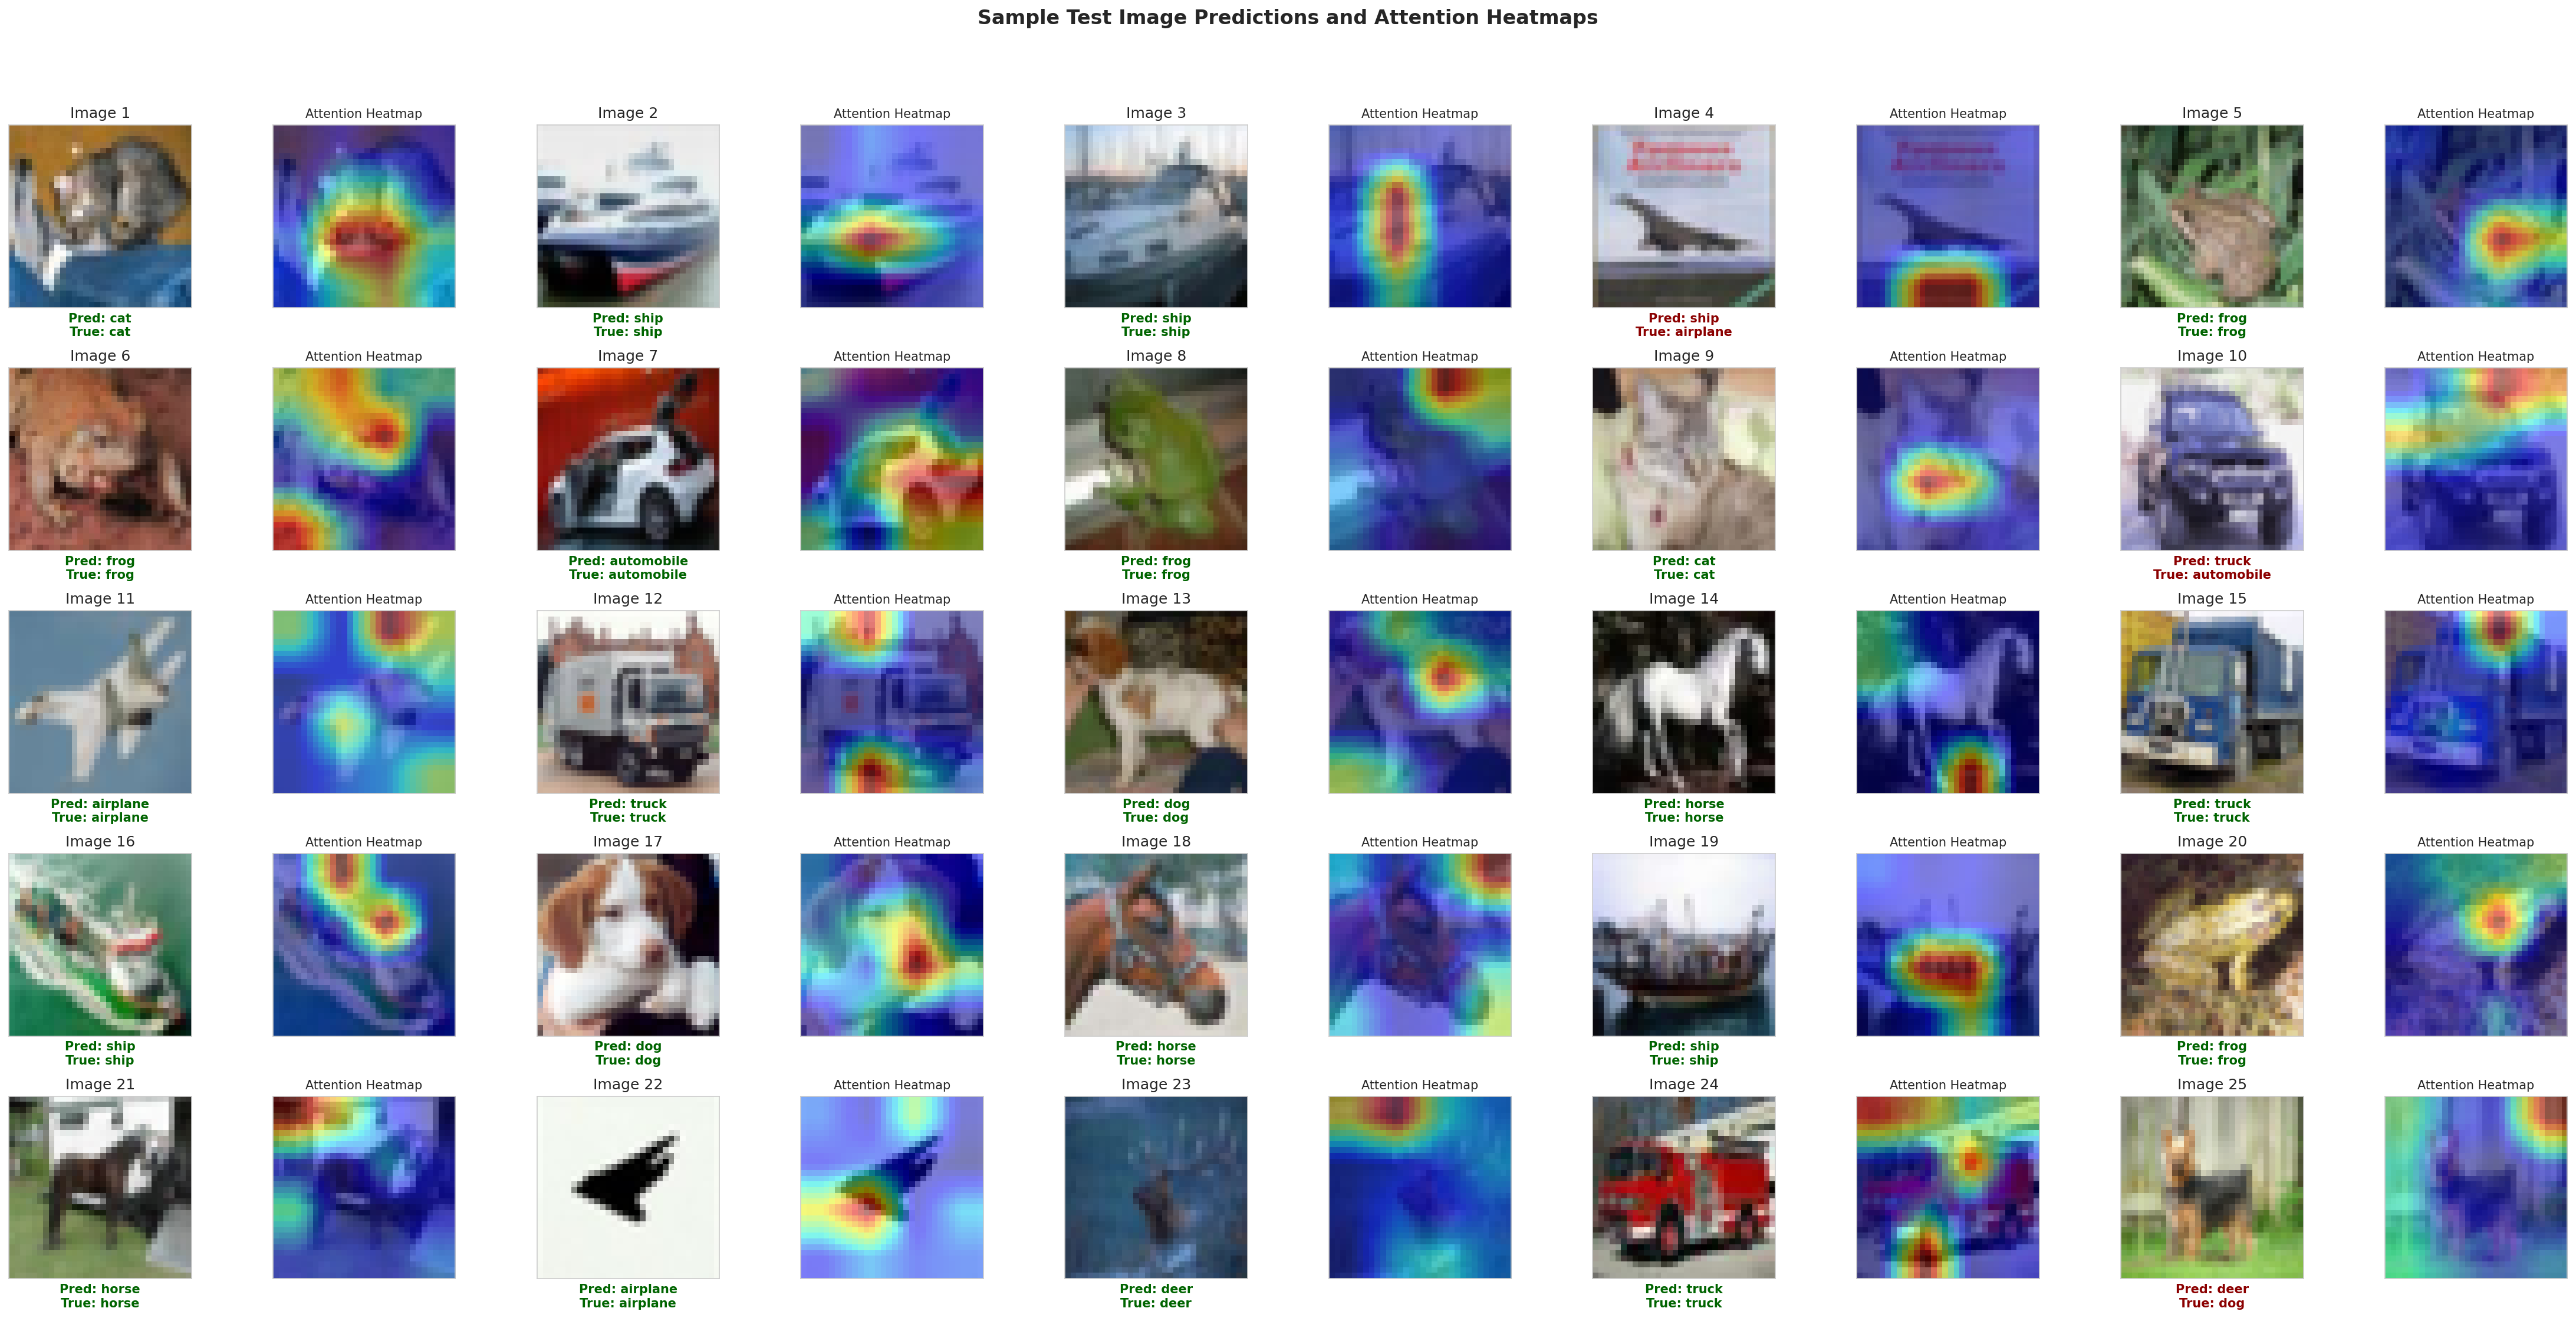

In [12]:
print("\nVisualizing some predictions with attention heatmaps...")

# Create a functional model to get outputs at specific layers
# This model will output the final predictions AND the attention map
attention_model_with_preds = Model(inputs=model.input,
                                   outputs=[model.output,  # Final predictions
                                            post_attention_features_tensor, # Features after attention for spatial dim reference
                                            attention_scores_tensor]) # Raw attention scores

# Get predictions and attention data for all test images
predictions, post_attention_features_all, attention_scores_all = \
    attention_model_with_preds.predict(test_images)

num_images_to_display = 25 # Display 25 images
images_per_row = 5
images_per_column = num_images_to_display // images_per_row

# Calculate figure size based on the number of images and desired subplot size
# Each pair of image + heatmap will take up 2 columns
# Each row will have 'images_per_row' pairs
# Figure width = (images_per_row * 2 columns per pair) * subplot width
# Figure height = images_per_column * subplot height
subplot_width = 3  # Adjust as needed
subplot_height = 3 # Adjust as needed
plt.figure(figsize=(images_per_row * 2 * subplot_width, images_per_column * subplot_height), dpi=150)

for i in range(num_images_to_display):
    # Determine the subplot position (row, column)
    row = i // images_per_row
    col = i % images_per_row

    # Original Image Plot
    plt.subplot(images_per_column, images_per_row * 2, row * (images_per_row * 2) + col * 2 + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(test_images[i])

    predicted_label_index = np.argmax(predictions[i])
    true_label_index = test_labels[i][0]

    predicted_label_name = class_names[predicted_label_index]
    true_label_name = class_names[true_label_index]

    if predicted_label_index == true_label_index:
        color = 'darkgreen'  # More distinct green for correct
    else:
        color = 'darkred'  # More distinct red for incorrect

    plt.xlabel(f"Pred: {predicted_label_name}\nTrue: {true_label_name}", color=color, fontsize=10,
               fontweight='bold')  # Bold labels
    plt.title(f"Image {i + 1}")


    # Attention Heatmap Plot
    plt.subplot(images_per_column, images_per_row * 2, row * (images_per_row * 2) + col * 2 + 2)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)

    # Process Attention Scores for Heatmap for this image
    attention_scores_val = attention_scores_all[i]
    attention_map_flat = np.mean(attention_scores_val, axis=0)

    h_prime, w_prime, _ = post_attention_features_all.shape[1:]
    attention_map_2d = attention_map_flat.reshape(h_prime, w_prime)
    attention_map_2d = (attention_map_2d - attention_map_2d.min()) / (attention_map_2d.max() - attention_map_2d.min() + 1e-8)

    # Display the original image and overlay the attention heatmap
    plt.imshow(test_images[i])
    resized_attention_map = tf.image.resize(tf.expand_dims(attention_map_2d, -1),
                                            test_images[i].shape[:2],
                                            method='bilinear')[..., 0]
    plt.imshow(resized_attention_map, cmap='jet', alpha=0.5)  # Overlay attention map with transparency
    plt.title('Attention Heatmap', fontsize=10)


plt.suptitle('Sample Test Image Predictions and Attention Heatmaps', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout(rect=[0, 0.03, 1, 0.98])
plt.show()

## Class-wise Prediction Distribution (Confusion Matrix)

A confusion matrix is a powerful tool for visualizing the performance of a classification model, especially for multi-class problems. It shows the counts of true positive, true negative, false positive, and false negative predictions for each class.

*   **Rows:** Represent the true labels of the instances.
*   **Columns:** Represent the predicted labels by the model.
*   **Diagonal Elements:** Show the number of instances where the true label matches the predicted label (correct classifications).
*   **Off-Diagonal Elements:** Show misclassifications. For example, the cell in row 'cat' and column 'dog' shows how many images of cats were incorrectly classified as dogs.


313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step


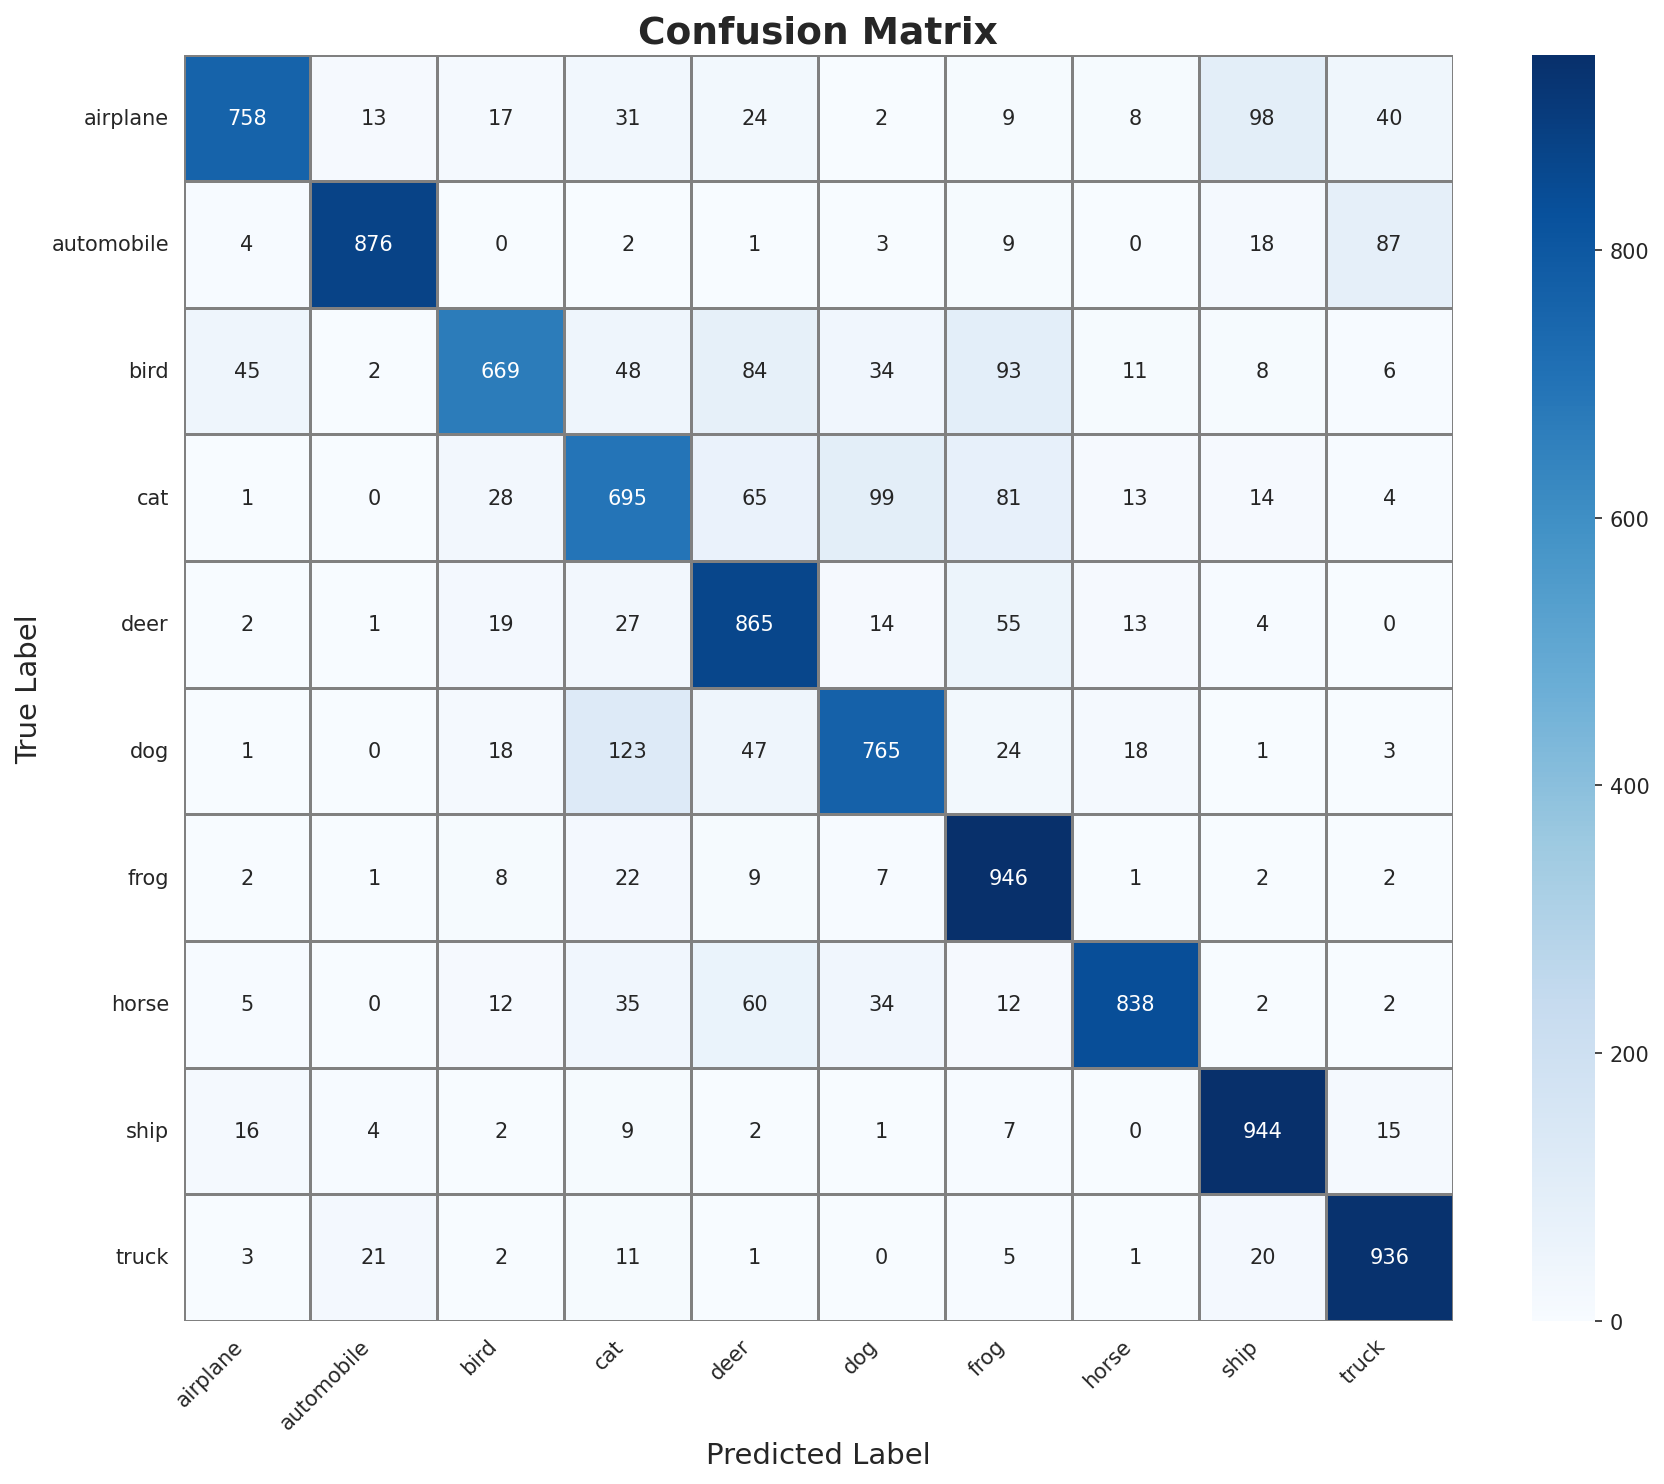

In [13]:
# Get predicted labels for the test set
y_pred_probs = model.predict(test_images)
y_pred_classes = np.argmax(y_pred_probs, axis=1)
y_true_classes = test_labels.flatten()

# Calculate the confusion matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)

plt.figure(figsize=(12, 10), dpi=150) # Larger figure, higher DPI
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=True, # Added color bar
            xticklabels=class_names, yticklabels=class_names, linewidths=.7, linecolor='gray', annot_kws={"size": 10}) # Sharper lines, adjusted annotation size
plt.title('Confusion Matrix', fontsize=18, fontweight='bold')
plt.xlabel('Predicted Label', fontsize=14)
plt.ylabel('True Label', fontsize=14)
plt.xticks(rotation=45, ha='right', fontsize=10) # Adjust font size for ticks
plt.yticks(rotation=0, fontsize=10)
plt.tight_layout()
plt.show()

## Visualize Attention Maps and Features

This section visualizes the effect of the attention mechanism by showing:

1.  **Original Image:** The input image.
2.  **Features Before Attention:** A heatmap representing the average activation of the feature maps right before they are fed into the attention layer. This shows what the CNN has learned up to that point.
3.  **Features After Attention:** A heatmap representing the average activation of the feature maps after the attention layer. Comparing this to the "Before" heatmap can reveal how the attention mechanism has potentially re-weighted or enhanced certain features.
4.  **Attention Heatmap:** An overlayed heatmap on the original image. This heatmap is derived from the attention scores and visually indicates which spatial regions in the feature map (and by extension, in the original image) were most attended to by the model when making its prediction. Brighter areas in the heatmap indicate higher attention weights – meaning those regions were considered more important by the self-attention layer.

**Interpretation:**

*   By examining the "Attention Heatmap" along with the original image, you can gain insight into which parts of the image the model is focusing on. For example, for a "cat" image, the heatmap might be concentrated around the cat's face or body.


Visualizing attention maps...
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


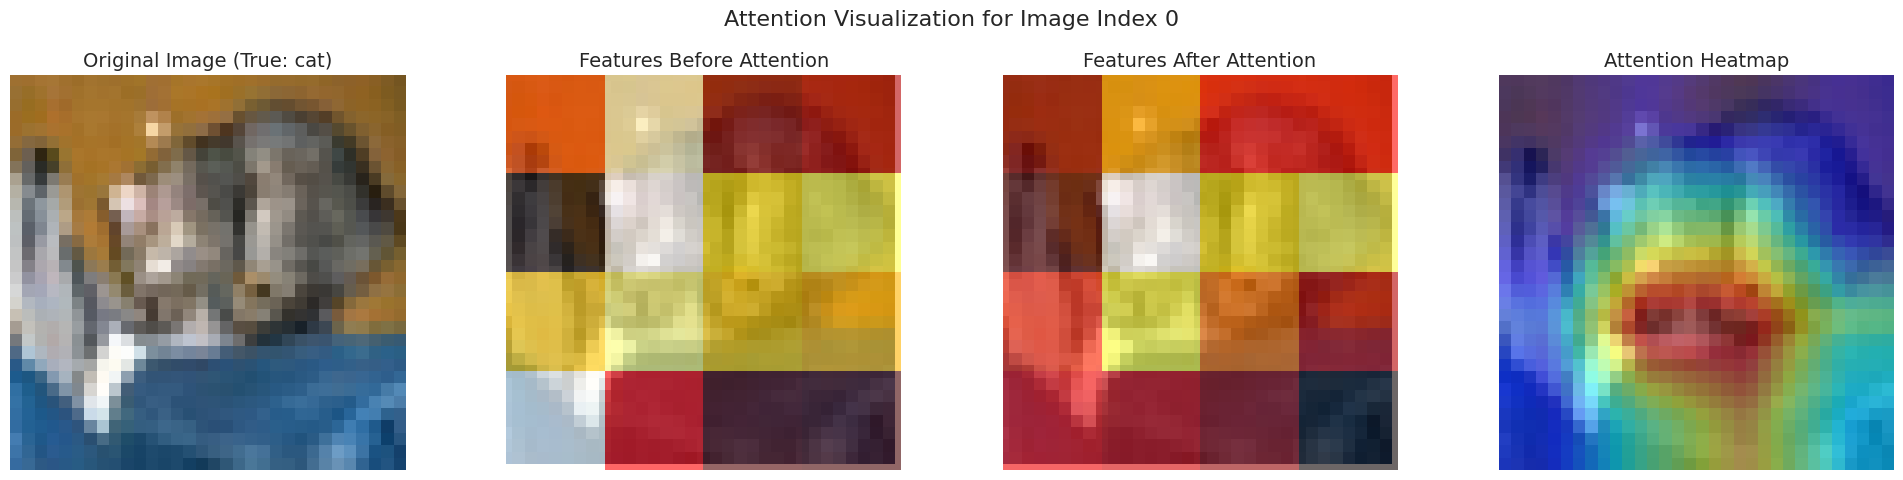

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


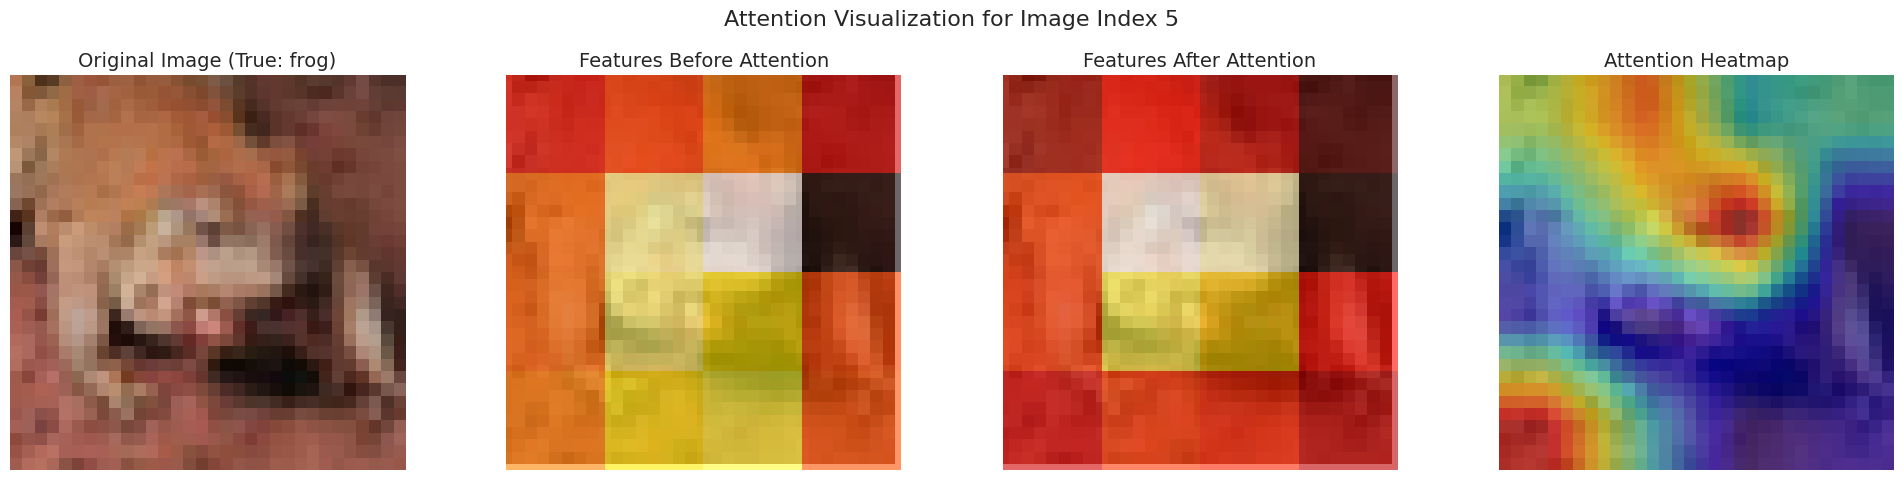

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


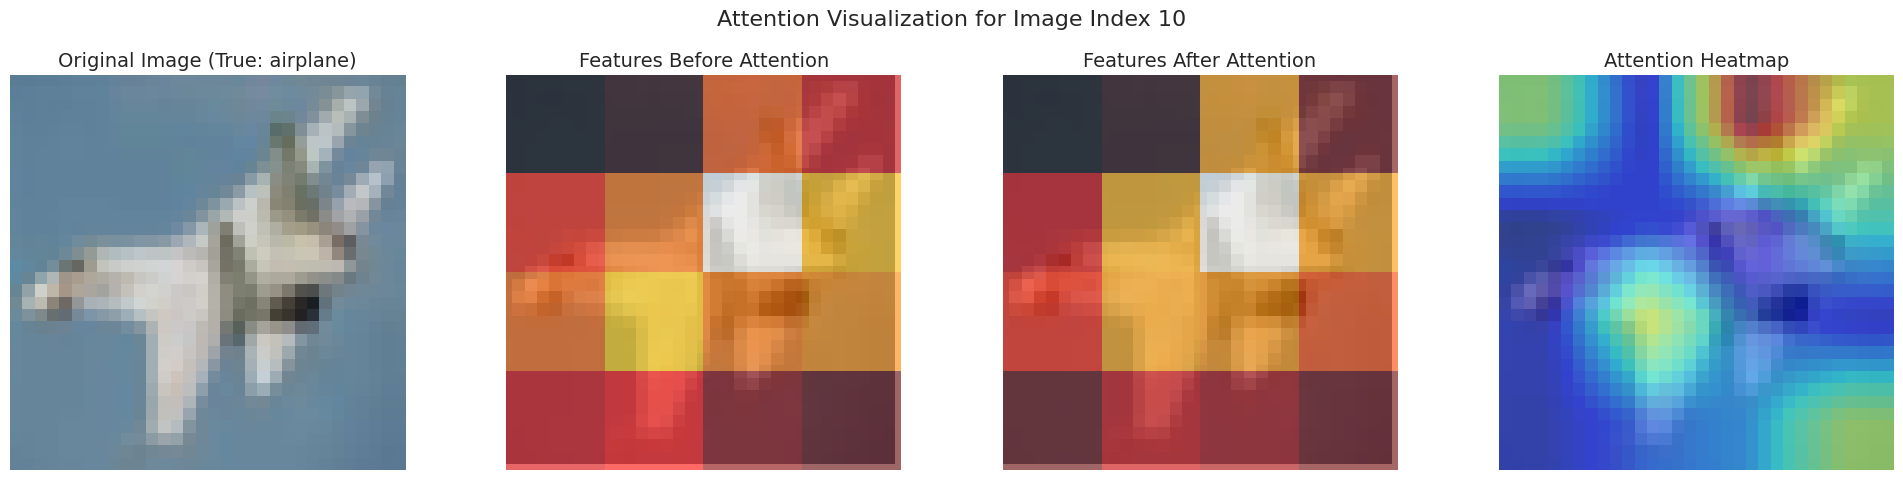

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


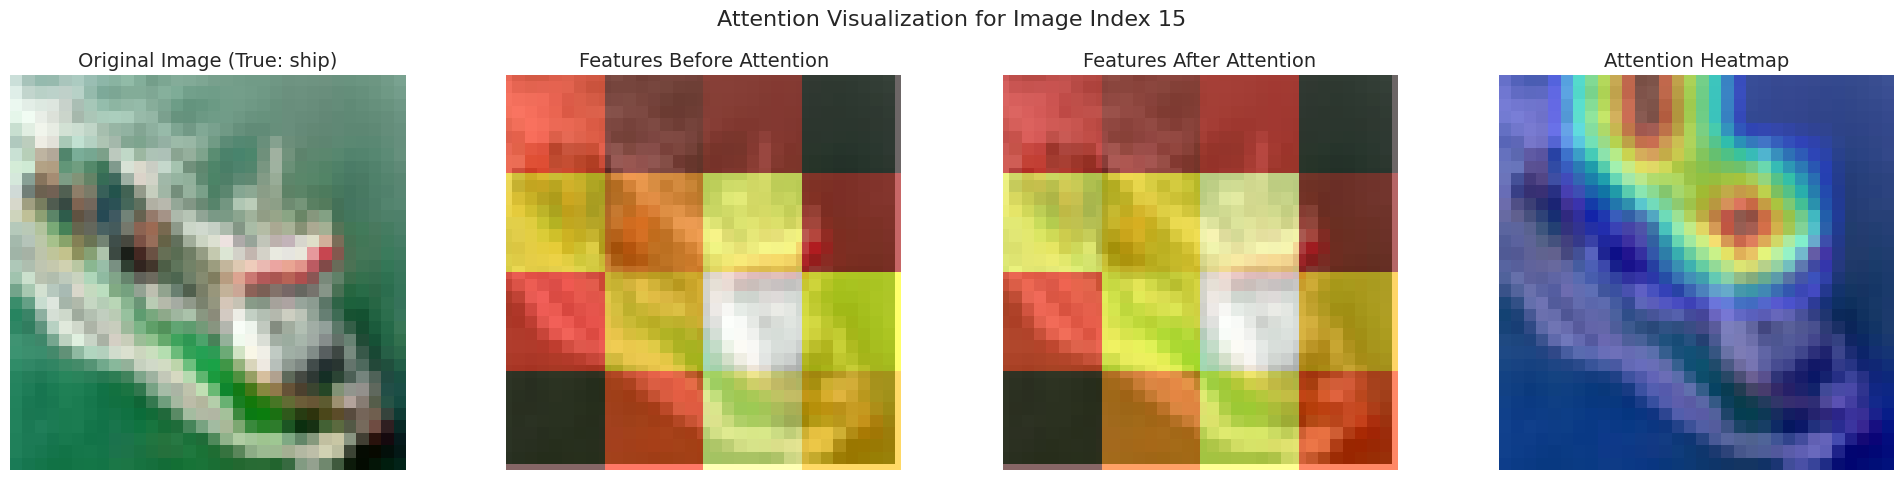

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


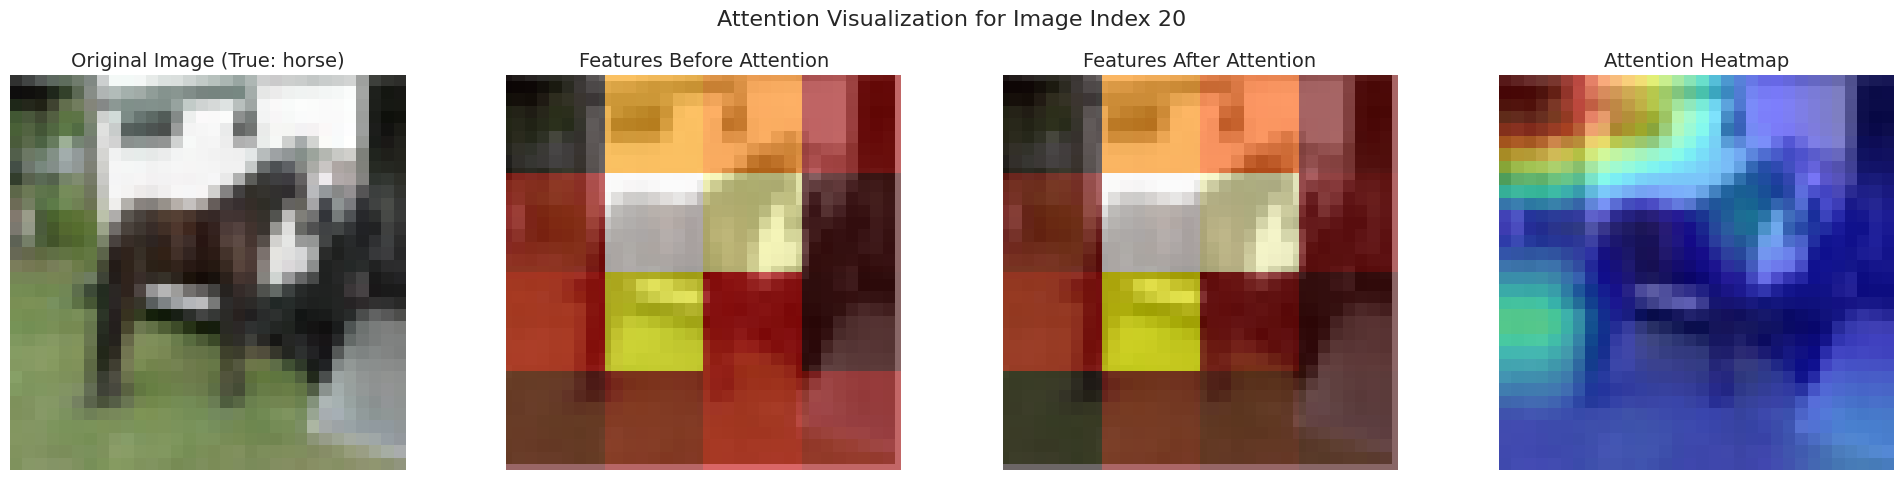

In [14]:
print("\nVisualizing attention maps...")
# Create a functional model to get outputs at specific layers

attention_model_visualizer = Model(inputs=model.input,
                                   outputs=[pre_attention_features_tensor, # Features before attention
                                            post_attention_features_tensor, # Features after attention
                                            attention_scores_tensor]) # Raw attention scores


def visualize_attention_map(image_index):
    """
    Visualizes the original image, features before/after attention, and the attention heatmap.
    """
    original_image = test_images[image_index]
    original_label = class_names[test_labels[image_index][0]]

    # Add batch dimension
    input_image = np.expand_dims(original_image, axis=0)

    # Get outputs from the visualization model
    features_before_attention, features_after_attention, attention_scores_val = \
        attention_model_visualizer.predict(input_image)

    # --- Process Features for Visualization ---
    # Average across channels for a general heatmap of activity
    avg_features_before = np.mean(features_before_attention[0], axis=-1)
    avg_features_after = np.mean(features_after_attention[0], axis=-1)

    # --- Process Attention Scores for Heatmap ---
    # attention_scores_val shape: (1, N, N) where N = h*w
    # To get a single heatmap (which position was attended to most),
    # we sum/average across the 'query' dimension (axis=0 after batch dim).
    # This gives us a (N_keys,) vector, where each element is the accumulated attention for that key position.
    attention_map_flat = np.mean(attention_scores_val[0], axis=0) # Sum or mean. Mean is generally good.

    # Get the spatial dimensions of the feature map (H', W')
    h_prime, w_prime, _ = features_before_attention.shape[1:] # e.g., 4x4

    # Reshape the attention map from (N_keys,) to (H', W')
    attention_map_2d = attention_map_flat.reshape(h_prime, w_prime)

    # Normalize the attention map for better visualization (0 to 1)
    # This ensures the heatmap colors are consistent
    attention_map_2d = (attention_map_2d - attention_map_2d.min()) / (attention_map_2d.max() - attention_map_2d.min() + 1e-8)

    # Optional: Apply a power or exponential to emphasize differences,
    # but be careful not to lose information.
    # attention_map_2d = np.power(attention_map_2d, 2) # Example to sharpen contrasts

    # --- Plotting ---
    fig, axes = plt.subplots(1, 4, figsize=(20, 5)) # Increased subplot count for attention map

    # Original Image
    axes[0].imshow(original_image)
    axes[0].set_title(f'Original Image (True: {original_label})', fontsize=14)
    axes[0].axis('off')

    # Features Before Attention (Heatmap overlaid)
    axes[1].imshow(original_image, cmap='gray') # Show original image faintly
    axes[1].imshow(avg_features_before, cmap='hot', alpha=0.6, extent=[0, original_image.shape[1], original_image.shape[0], 0]) # Overlay heatmap, use extent for alignment
    axes[1].set_title('Features Before Attention', fontsize=14)
    axes[1].axis('off')

    # Features After Attention (Heatmap overlaid)
    axes[2].imshow(original_image, cmap='gray') # Show original image faintly
    axes[2].imshow(avg_features_after, cmap='hot', alpha=0.6, extent=[0, original_image.shape[1], original_image.shape[0], 0]) # Overlay heatmap, use extent for alignment
    axes[2].set_title('Features After Attention', fontsize=14)
    axes[2].axis('off')

    # Attention Map (Overlayed Heatmap)
    axes[3].imshow(original_image) # Show original image beneath the heatmap
    # Resize the attention map to the original image dimensions for overlay
    resized_attention_map = tf.image.resize(tf.expand_dims(attention_map_2d, -1),
                                            original_image.shape[:2],
                                            method='bilinear')[...,0]
    axes[3].imshow(resized_attention_map, cmap='jet', alpha=0.5) # Overlay attention map with transparency
    axes[3].set_title('Attention Heatmap', fontsize=14)
    axes[3].axis('off')


    plt.suptitle(f'Attention Visualization for Image Index {image_index}', fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()


# Choose a few test image indices to visualize
image_indices_to_visualize = [0, 5, 10, 15, 20] # Example indices

for idx in image_indices_to_visualize:
    visualize_attention_map(idx)
